# Dispatchable Renewable Electricity Offers Higher Energy Return on Investment than Carbon Capture and Storage Under Realistic Conditions 
*Sgouridis, Carbajales-Dale, Csala, Chiesa, Bardi*

Use this Jupyter workbook to reproduce all results presented in the paper.

<p>This is document has been created using  <a target="_blank" href="http://jupyter.org/">Jupyter Notebook</a> in the <a target="_blank" href="https://store.continuum.io/cshop/anaconda/">Anaconda</a> distribution and it can be edited and run in <i>active</i> mode by clicking download in top right corner of this page. The code is partitioned into sections, called <i>cells</i>. When you are using this workbook in <i>active</i> mode, double-click on a cell to edit it and then run using <code>Ctrl + Enter</code>. Hitting <code>Shift + Enter</code> runs the code and steps into the next cell, while <code>Alt + Enter</code> runs the code and adds a new, empty cell. If you are running this notebook on a presonal computer, you will need a machine with at least <i>1GB</i> of memory (<i>2GB</i> recommended) and a processor of <i>1GHz</i>.

Import dependencies

In [1]:
import pandas as pd, matplotlib.pyplot as plt, numpy as np
from matplotlib.colors import BoundaryNorm
from matplotlib.ticker import MaxNLocator
import matplotlib.patches as patches
import matplotlib.lines as lines
%matplotlib inline
import sys, string
from sympy import *
init_printing() 
print 'Running on Python',sys.version

Running on Python 2.7.15 |Anaconda, Inc.| (default, May  1 2018, 18:37:09) [MSC v.1500 64 bit (AMD64)]


### Fossil fuels part

#### Equations

In [2]:
var('EROEI E_out E_in');
eq_S1=Eq(EROEI,E_out/E_in)
eq_S1

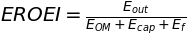

In [3]:
var('E_cap E_f E_OM');
eq_S1i=Eq(EROEI,E_out/(E_cap+E_OM+E_f))
eq_S1i

In [4]:
var('L s_OM');
eq_S2i=Eq(E_in,E_cap*(1+L*s_OM)+E_f)
eq_S2i

In [5]:
var('P L cf');
eq_S2ii=Eq(E_out,P*cf*L)
eq_S2ii

In [6]:
var('E_el');
eq_S2iii=Eq(E_out,E_el)
eq_S2iii

In [7]:
e=Symbol('eta')
var('E_th');
eq_S2iv=Eq(E_th,P*cf*L/e)
eq_S2iv

In [8]:
var('EROEI_th');
eq_S3i=Eq(E_f,E_th/EROEI_th)
eq_S3i

In [9]:
#define pretty variable substituion function
def sub(var,eq):
    return [var,solve(eq,var)[0]]
#create multiple substituion method by chaining
def multisub(eq0,msub):
    for i in range(len(msub)/2):
        eq0=eq0.subs([sub(msub[i*2],msub[i*2+1])])
    return eq0

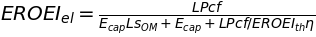

In [10]:
var('EROEI_el');
eq_S3=Eq(EROEI_el,multisub(eq_S1,[E_out,eq_S2ii,E_in,eq_S2i,E_f,eq_S3i,E_th,eq_S2iv]).rhs)
eq_S3

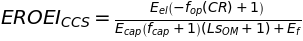

In [11]:
var('CR f_op EROEI_CCS f_cap');
eq_S4=Eq(EROEI_CCS,E_el*(1-f_op(CR))/(E_cap*(1+f_cap)*(1+L*s_OM)+E_f))
eq_S4

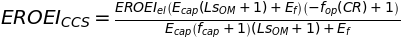

In [12]:
var('CR f_op EROEI_CCS f_cap');
eq_S5=Eq(EROEI_CCS,(1-f_op(CR))*(E_cap*(1+L*s_OM)+E_f)*EROEI_el/(E_cap*(1+f_cap)*(1+L*s_OM)+E_f))
eq_S5

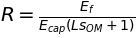

In [13]:
var('R');
eq_S6i=Eq(R,E_f/(E_cap*(1+L*s_OM)))
eq_S6i

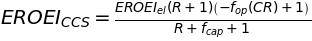

In [14]:
eq_S6=Eq(EROEI_CCS,(1-f_op(CR))*(R+1)*EROEI_el/(R+1+f_cap))
eq_S6

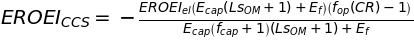

In [15]:
eq_S5.simplify()

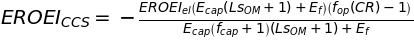

In [16]:
eq_S6.subs(R,eq_S6i.rhs).simplify()

In [17]:
#eq_S6 is correct!
eq_S6.subs(R,eq_S6i.rhs).simplify()==eq_S5.simplify()

True

#### Simulation

Using the formula in Eq.4 and the plant values from the Table S1 calculate the $EROEI_{el}$ for all capacity factors $CF$s between 50 and 90. We then use these values as a proxy to create an a adjustment factor for the $EROEI_{el}$ due to the indirect effect of the change of the capacity factor.

In [103]:
import xlwings as xw #will open a MS Excel application, let it run in the background
wb = xw.Book('plants.xlsx')

In [116]:
def eroei_r_getter(CF=100,EROEI_fuel_coal=58,EROEI_fuel_gas=87):
    xw.Range('L7').value=CF/100.0 #hard-coded Excel workbook cell ID for capacity factor
    xw.Range('M8').value=EROEI_fuel_coal #hard-coded Excel workbook cell ID for EROEI_fuel for Coal
    xw.Range('O8').value=EROEI_fuel_gas #hard-coded Excel workbook cell ID for EROEI_fuel for Gas
    wb.save() #write new values
    df=pd.read_excel('plants.xlsx',usecols=range(10,24)).loc[[37,38]]
    df=df[df.columns[1::2]]
    df.columns=['IGCC 1','IGCC 3','IGCC 5','PC 9','PC 11','NGCC 13']
    df.index=['EROEI_el','R']
    df['IGCC']=(df['IGCC 1']+df['IGCC 3']+df['IGCC 5'])/3.0
    df['PC']=(df['PC 9']+df['PC 11'])/2.0
    df['NGCC']=df['NGCC 13']
    return df[['IGCC','PC','NGCC']]

In [117]:
eroei_r_getter(95,58,87)

,IGCC,PC,NGCC
EROEI_el,12.0177,14.0583,31.9783
R,1.5745,2.06751,2.91996


In [118]:
CFs=[i*5 for i in range (10,21)]
CFs

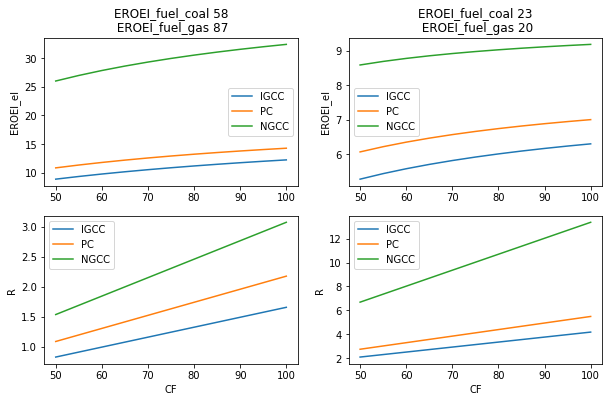

In [149]:
EROEI_fuel=[[58,87],[23,20]]
fig,axes=plt.subplots(2,2,figsize=(10,6))
for j in range(len(EROEI_fuel)):
    EROEI_fuel_coal=EROEI_fuel[j][0]
    EROEI_fuel_gas=EROEI_fuel[j][1]
    dfs1=[]
    dfs2=[]
    for i in range(len(CFs)):
        df=eroei_r_getter(CFs[i],EROEI_fuel_coal,EROEI_fuel_gas)
        df1=df.loc['EROEI_el']
        df2=df.loc['R']
        df1.name=CFs[i]
        df2.name=CFs[i]
        dfs1.append(df1)
        dfs2.append(df2)
    dfs=pd.concat(dfs1,axis=1)
    ax=axes[0][j]
    dfs.T.plot(ax=ax)
    ax.set_ylabel('EROEI_el')
    ax.set_title('EROEI_fuel_coal '+str(EROEI_fuel_coal)+'\n EROEI_fuel_gas '+str(EROEI_fuel_gas))    
    dfs=pd.concat(dfs2,axis=1)
    ax=axes[1][j]
    dfs.T.plot(ax=ax)
    ax.set_xlabel('CF')
    ax.set_ylabel('R')

We need to create a energy penalty conversion ratio for the Capture ratio $CR$. We use the Energy penalty figure S1. We then use this value to adjust the fvalue of the operational energy penalty $f_{op}$.

|CR | energy penalty  |
|--|--|
|60| 7.8  |
|90| 11.8|

In [150]:
CR=[90,60]
CR_ratio=[1, 7.8/11.8]
CR_ratio

Define $EROEI_{CCS}$ calcuator function `eroei_ccs_cycler`, including minimums and maximums over $f_{op}$ and $f_{cap}$.

In [154]:
names

['NGCC\nGas', 'Pulverized\nCoal', 'IGCC\nCoal']

In [163]:
def fuel_name_converter(fuel):
    if fuel=='NGCC\nGas': return 'NGCC'
    elif fuel=='IGCC\nCoal': return 'IGCC'
    elif fuel=='Pulverized\nCoal': return 'PC'
    else: return None

In [178]:
def eroei_ccs_cycler(names, eroei_fuels, t0s, CF, CR_ratio, fop, fcap, verbose=False):
    eroei_ccs=np.zeros([len(names),len(CF),len(CR_ratio),len(fop),len(fcap)])
    eroei_ccs_min=np.zeros([len(names),len(CF),len(CR_ratio)])+1000
    eroei_ccs_max=np.zeros([len(names),len(CF),len(CR_ratio)])
    eroei_el_cf=np.zeros([len(names),len(CF)])
    R_cf=np.zeros([len(names),len(CF)])
    for i in range(len(names)):
        if verbose: print('Calculating '+names[i].replace('\n',' ')+'...')
        for j in range(len(CF)):
            eroei_r=eroei_r_getter(CF[j],eroei_fuels[i],eroei_fuels[i])[fuel_name_converter(names[i])]
            #convert fuel EROEI to EROEI_el using the CF converstion table
            eroei_el_cf[i][j]=eroei_r.loc['EROEI_el']
            #calculate R using the CF converstion table
            R_cf[i][j]=eroei_r.loc['R']
            for r in range(len(CR_ratio)):
                for k in range(len(fop)):
                    for l in range(len(fcap)):
                        #calculate eoris over maps using eq_S6
                        eroei_ccs[i][j][r][l,k]=(1-fop[k]*CR_ratio[r]/100.0)*\
                            ((R_cf[i][j]+1)/(R_cf[i][j]+1+fcap[l]/100.0))*\
                            eroei_el_cf[i][j]

                        #calculate min-maxes
                        for t0x in range(len(t0s[i])/2):
                            for t0y in range(len(t0s[i])/2,len(t0s[i])):
                                x=t0s[i][t0x]
                                y=t0s[i][t0y]
                                if ((abs(fop[k]-x)<0.5)and(abs(fcap[l]-y)<1.5)):
                                    eroei_ccs_max[i][j][r]=max(eroei_ccs_max[i][j][r],eroei_ccs[i][j][r][l,k])
                                    eroei_ccs_min[i][j][r]=min(eroei_ccs_min[i][j][r],eroei_ccs[i][j][r][l,k])
                if verbose:
                    print('CF='+str(CF[j])+', CR='+str(CR[r])+\
                      ', EROEI_fuel='+str(eroei_fuels[i])+\
                      ', EROEI_el_CF_'+str(CF[j])+'%='+str(np.round(eroei_el_cf[i][j],2))+\
                      ', R_CF_'+str(CF[j])+'%='+str(np.round(R_cf[i][j],2))+\
                      ', EROEI_CCS - min='+str(np.round(eroei_ccs_min[i][j][r],2))+\
                      ', max='+str(np.round(eroei_ccs_max[i][j][r],2)))
    return eroei_el_cf, R_cf, eroei_ccs, eroei_ccs_min, eroei_ccs_max

Different style plot with actual EROEI values on the color maps, and also display _min_ and _max_ values for the $EROEI_{CCS}$.

In [179]:
#Simulation options
fop=np.linspace(5,40,100)
fcap=np.linspace(10,120,100)
CF=[55,85]
title=u'$EROEI_{CCS}$ comparison for Coal and Gas'
#eroei_els=[30,13,13] #varies by name
#eroei_els=[32.4,14.3,12.25] #100% CF value from the CF converstion table
eroei_fuels=[87,58,58] #100% CF value from the CF converstion table
names=['NGCC\nGas','Pulverized\nCoal','IGCC\nCoal'] 
t0s=[[12,20,58,110],[17,31,45,95],[15,28,23,40]]  # [fop range [min,max], fcap] by each name

eroei_el_cf, R_cf, eroei_ccs, eroei_ccs_min, eroei_ccs_max=eroei_ccs_cycler(names, eroei_fuels, t0s, CF, CR_ratio, fop, fcap, verbose=True)

Calculating NGCC Gas...
CF=55, CR=90, EROEI_fuel=87, EROEI_el_CF_55%=26.97, R_CF_55%=1.69, EROEI_CCS - min=15.23, max=19.67
CF=55, CR=60, EROEI_fuel=87, EROEI_el_CF_55%=26.97, R_CF_55%=1.69, EROEI_CCS - min=16.54, max=20.56
CF=85, CR=90, EROEI_fuel=87, EROEI_el_CF_85%=31.05, R_CF_85%=2.61, EROEI_CCS - min=18.95, max=23.69
CF=85, CR=60, EROEI_fuel=87, EROEI_el_CF_85%=31.05, R_CF_85%=2.61, EROEI_CCS - min=20.57, max=24.76
Calculating Pulverized Coal...
CF=55, CR=90, EROEI_fuel=58, EROEI_el_CF_55%=11.36, R_CF_55%=1.2, EROEI_CCS - min=5.45, max=7.87
CF=55, CR=60, EROEI_fuel=58, EROEI_el_CF_55%=11.36, R_CF_55%=1.2, EROEI_CCS - min=6.29, max=8.41
CF=85, CR=90, EROEI_fuel=58, EROEI_el_CF_85%=13.54, R_CF_85%=1.85, EROEI_CCS - min=6.98, max=9.76
CF=85, CR=60, EROEI_fuel=58, EROEI_el_CF_85%=13.54, R_CF_85%=1.85, EROEI_CCS - min=8.05, max=10.42
Calculating IGCC Coal...
CF=55, CR=90, EROEI_fuel=58, EROEI_el_CF_55%=9.37, R_CF_55%=0.91, EROEI_CCS - min=5.52, max=7.17
CF=55, CR=60, EROEI_fuel=58, ERO

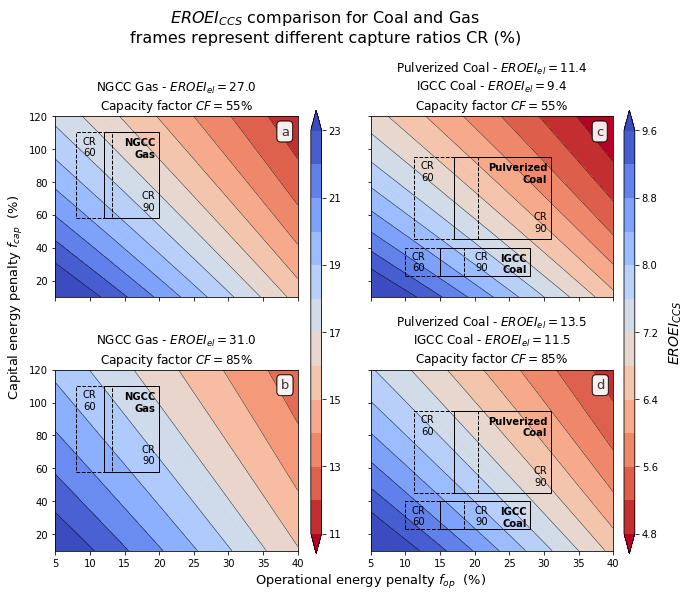

In [180]:
#Plotting options
fig,axes=plt.subplots(2,2,figsize=(10,8))
plt.subplots_adjust(hspace=0.4)
plt.subplots_adjust(wspace=0.3)

eroei_ccs_scale_min2=1.2
eroei_ccs_scale_max2=2.3
ls=['-','--']
ls0='-'
lw0=0.5
t_x_offset=[6.5,12.5,6]
t_y_offset=[47,45,14]
breaker=['\n','\n','\n']

for i in range(len(axes)):
    for j in range(len(axes[i])):
        eroei_el=eroei_el_cf[j][i]
        ax=axes[i][j]
        X, Y = np.meshgrid(fop, fcap)
        z = eroei_ccs[j][i][0]#*100.0/eroei_el #third index is CR, keep at 0, its relative
        levels = MaxNLocator(nbins=12).tick_values(eroei_el/eroei_ccs_scale_max2, eroei_el/eroei_ccs_scale_min2)
        levels2 = MaxNLocator(nbins=8).tick_values(eroei_el/eroei_ccs_scale_max2, eroei_el/eroei_ccs_scale_min2)
        cmap = plt.get_cmap('coolwarm_r')
        im = ax.contourf(X, Y, z, cmap=cmap, levels=levels,extend='both')
        im2 = ax.contour(X, Y, z, levels=levels,extend='both',colors='k',linewidths=0.4)
        im3 = ax.contour(X, Y, z, levels=levels2,extend='both',colors='k',linewidths=0.01)
        ax.set_xlim((fop.min(),fop.max()))
        ax.set_ylim((fcap.min(),fcap.max()))
        if (i==0):
            fig.subplots_adjust(right=0.9)
            cbar_ax = fig.add_axes([0.48+0.435*j, 0.12, 0.015, 0.77])
            fig.colorbar(im, cax=cbar_ax)
            if j==1: cbar_ax.set_ylabel(u'$EROEI_{CCS}$',fontsize=14,labelpad=10)

        for m in range(len(CR_ratio)):
            n=0
            for ti in range(len(t0s)):
                if (((j==1)and(ti==2))or(ti==j)):
                    t0=t0s[ti]
                    t=[t0[0]*CR_ratio[m],t0[1]*CR_ratio[m],t0[2]+n,t0[3]+n]
                    rect = patches.Rectangle((t[0],t[2]),t[1]-t[0],t[3]-t[2],ls=ls[m],
                                             edgecolor='k',facecolor='none')
                    ax.add_patch(rect)

                    if m==1:
                        ax.text(t[0]+2,t[3]-14,'CR\n'+str(CR[m]),horizontalalignment='center')
                    else:
                        ax.text(t[0]+t_x_offset[ti],t[3]-t_y_offset[ti],'CR'+breaker[ti]+str(CR[m]),
                                horizontalalignment='center')
                    if m==0: 
                        ax.text(t[1]-0.5,t[3]-15,names[ti],horizontalalignment='right',weight='bold')
                    if (ti==1)and(m==1):
                        line = lines.Line2D((t0[0],t[1]),((t0[2]+t0[3])/2,(t[2]+t[3])/2),color='k',
                                            linewidth=lw0,ls=ls0)
                        #ax.add_line(line)  

        if j==0:
            ax.set_title(names[0].replace('\n',' ')+' - $EROEI_{el}='+\
                     str(round(eroei_el_cf[0][i],1))+\
                         u'$\nCapacity factor $CF='+str(CF[i])+'$%')
        else:
            ax.set_title(names[1].replace('\n',' ')+' - $EROEI_{el}='+\
                     str(round(eroei_el_cf[1][i],1))+'$\n'+\
                         names[2].replace('\n',' ')+' - $EROEI_{el}='+\
                     str(round(eroei_el_cf[2][i],1))+\
                         u'$\nCapacity factor $CF='+str(CF[i])+'$%')
        ax.text(0.93, 0.95, string.ascii_lowercase[j*len(axes)+i],
            horizontalalignment='left',
            verticalalignment='top',
            transform=ax.transAxes,size=13,alpha=0.7,
                          bbox=dict(boxstyle="round", fc="w", alpha=0.7))
        ax.text(0.93, 0.95, string.ascii_lowercase[j*len(axes)+i],
            horizontalalignment='left',
            verticalalignment='top',
            transform=ax.transAxes,size=13,alpha=0.7,
                          bbox=dict(boxstyle="round", fc="w", alpha=0.7))
            
axes[1][1].set_xlabel('Operational energy penalty $f_{op}$  (%)',fontsize=13,x=0)
axes[0][0].set_ylabel('Capital energy penalty $f_{cap}$  (%)',fontsize=13,y=0)        
axes[0][1].set_yticklabels('')   
axes[1][1].set_yticklabels('')   
axes[0][0].set_xticklabels('')   
axes[0][1].set_xticklabels('')  
plt.suptitle(title+'\nframes represent different capture ratios CR (%)',fontsize=16,y=1.07)
plt.savefig('plot/fig2.png',dpi=150,bbox_inches = 'tight', pad_inches = 0.1)
plt.show()

### Dispatchable Renewables Part

#### Equations

In [181]:
l=Symbol('lambda')
epse=Symbol('epsilon')
var('ESOI D');
eq_S7=Eq(ESOI,l*e*D/epse)
eq_S7

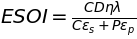

In [182]:
epsp=Symbol('epsilon_p')
epss=Symbol('epsilon_s')
var('D P C');
eq_S8=Eq(ESOI,C*l*e*D/(P*epsp+C*epss))
eq_S8

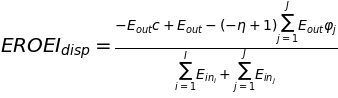

In [183]:
f=Symbol('varphi_j')
Ei=Symbol('E_{in_i}')
Ej=Symbol('E_{in_j}')
var('EROEI_disp c j i I J');
eq_S9=Eq(EROEI_disp,(E_out-(1-e)*Sum(f*E_out,(j,1,J))-c*E_out)/(Sum(Ei,(i,1,I))+Sum(Ej,(j,1,J))))
eq_S9

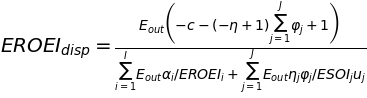

In [184]:
a=Symbol('alpha_i')
ej=Symbol('eta_j')
f=Symbol('varphi_j')
Ei=Symbol('E_{in_i}')
Ej=Symbol('E_{in_j}')
var('EROEI_i u_j ESOI_j');
eq_S10=Eq(EROEI_disp,(E_out*(1-(1-e)*Sum(f,(j,1,J))-c))/(Sum(E_out*a/EROEI_i,(i,1,I))+Sum((E_out*f*ej)/(ESOI_j*u_j),(j,1,J))))
eq_S10

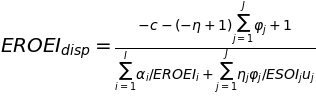

In [185]:
eq_S11=Eq(EROEI_disp,((1-(1-e)*Sum(f,(j,1,J))-c))/(Sum(a/EROEI_i,(i,1,I))+Sum((f*ej)/(ESOI_j*u_j),(j,1,J))))
eq_S11

#### Simulation

Define $EROEI_{disp}$ calcuator function `eroei_disp_cycler`, including minimums and maximums over $\varphi$.

In [186]:
def eroei_disp_cycler(ESOI, phi, eta, c, eroei_el):
    #eroei_disp=np.zeros([len(ESOI),len(phi),len(eroei_el)])
    eroei_disp=np.zeros([len(ESOI),len(eroei_el),len(phi)])
    for i in range(len(ESOI)):
        for j in range(len(phi)):
            for k in range(len(eroei_el)):
                #eq_S11
                #Also Eq. 6 from http://pubs.rsc.org/en/content/articlepdf/2013/ee/c3ee41973h
                eroei_disp[i][k,j]=(-c[i]-(+1-eta[i])*phi[j]+1)/\
                                    ((1.0/eroei_el[k])+(eta[i]*phi[j]/ESOI[i]))    
    return eroei_disp

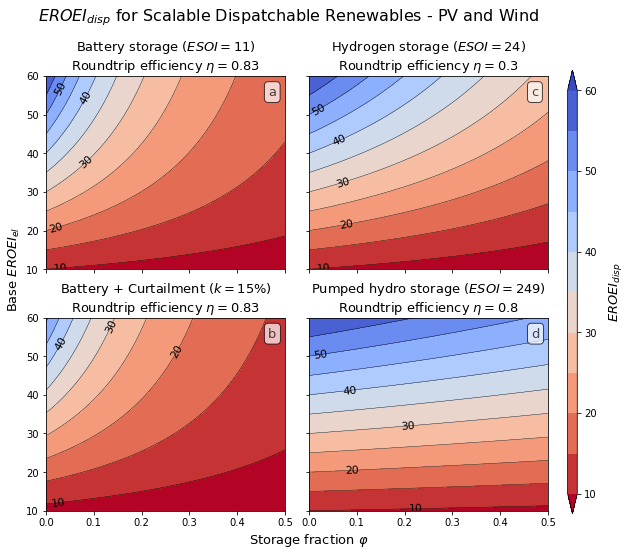

In [187]:
eroei_el=np.linspace(10,60,100)
phi=np.linspace(.0,.50,100)
ESOI=[11,24,11,249]
ESOI_tech=['Battery storage','Hydrogen storage','Battery + Curtailment','Pumped hydro storage']
eta=[0.83,0.3,0.83,0.8]
c=[0,0,0.15,0]

eroei_disp=eroei_disp_cycler(ESOI, phi, eta, c, eroei_el)

fig,axes=plt.subplots(2,2,figsize=(9,8))
plt.subplots_adjust(wspace=0.1)
plt.subplots_adjust(hspace=0.25)
contour_min=10
contour_max=60
for i in range(len(ESOI)):
        ax=axes[i/2][i%2]
        z = eroei_disp[i]
        levels = MaxNLocator(nbins=10).tick_values(contour_min, contour_max)
        levels2 = MaxNLocator(nbins=5).tick_values(contour_min, contour_max)
        cmap = plt.get_cmap('coolwarm_r')
        X, Y = np.meshgrid(phi, eroei_el)
        im = ax.contourf(X, Y, z, cmap=cmap, levels=levels,extend='both')
        im2 = ax.contour(X, Y, z, levels=levels,extend='both',colors='k',linewidths=0.4)
        im3 = ax.contour(X, Y, z, levels=levels2,extend='both',colors='k',linewidths=0.01)    
        ax.clabel(im3, fmt = '%i',inline=1, fontsize=11)
        if (i==0):
            fig.subplots_adjust(right=0.9)
            cbar_ax = fig.add_axes([0.93, 0.12, 0.015, 0.77])
            fig.colorbar(im, cax=cbar_ax)
            cbar_ax.set_ylabel(u'$EROEI_{disp}$',fontsize=13,labelpad=10)
        ax.set_xlim((phi.min(),phi.max()))
        ax.set_ylim((eroei_el.min(),eroei_el.max()))
        if (i!=2):
            ax.set_title(ESOI_tech[i]+u' ($ESOI='+str(ESOI[i])+\
                     '$)\nRoundtrip efficiency $\eta='+str(eta[i])+'$',fontsize=13)
        else:
            ax.set_title(ESOI_tech[i]+u' ($k='+str(int(c[i]*100))+\
                     '$%)\nRoundtrip efficiency $\eta='+str(eta[i])+'$',fontsize=13)
        ax.text(0.93, 0.95, string.ascii_lowercase[(i%2)*2+i/2],
                horizontalalignment='left',
                verticalalignment='top',
                transform=ax.transAxes,size=13,alpha=0.7,
                              bbox=dict(boxstyle="round", fc="w", alpha=0.7))
            
axes[1][1].set_xlabel('Storage fraction $\\varphi$',fontsize=13,x=0)
axes[0][0].set_ylabel('Base $EROEI_{el}$',fontsize=13,y=0)        
axes[0][1].set_yticklabels('')   
axes[1][1].set_yticklabels('')   
axes[0][0].set_xticklabels('')   
axes[0][1].set_xticklabels('')  
plt.suptitle(r'$EROEI_{disp}$ for Scalable Dispatchable Renewables - PV and Wind',fontsize=16,y=1)
plt.savefig('plot/fig3.png',dpi=150,bbox_inches = 'tight', pad_inches = 0.1)
plt.show()

Define convex hull function to get outermost points of sensitivity analysis area.

In [188]:
from scipy.spatial import ConvexHull

In [189]:
def convexhull(p):
    p = np.array(p)
    hull = ConvexHull(p)
    return p[hull.vertices,:]

Define wieldy color functions.

In [190]:
def cbrew(i):
    colors=['#984ea3',
            '#e41a1c',
            '#377eb8',
            '#018571',
            '#e66101']
    return colors[i]
def cbrew2(i):
    colors=['#984ea3',
            '#e41a1c',
            '#377eb8',
            '#4daf4a',
            '#ff7f00']
    return colors[i]

Define figure aspect ratio getter for labels.

In [191]:
from operator import sub
#https://stackoverflow.com/questions/41597177/get-aspect-ratio-of-axes#42014041
def get_aspect(ax):
    # Total figure size
    figW, figH = ax.get_figure().get_size_inches()
    # Axis size on figure
    _, _, w, h = ax.get_position().bounds
    # Ratio of display units
    disp_ratio = (figH * h) / (figW * w)
    # Ratio of data units
    # Negative over negative because of the order of subtraction
    data_ratio = sub(*ax.get_ylim()) / sub(*ax.get_xlim())

    return disp_ratio / data_ratio

Caclulate envelopes

In [255]:
#Fossil part
segments=400
eroei_el_ns=[np.linspace(20,87,segments),np.linspace(23,58,segments),np.linspace(23,58,segments)]   
CF100=[100] #since we are using EROEI_els directly in the sensitivity plots, we need no CF adjustment
eroei_el_cf_N, eroei_ccs_N, eroei_ccs_min_N, eroei_ccs_max_N=[],[],[],[]
for i in range(len(names)):
    print 'calculating '+names[i].replace('\n',' ')+' area...'
    eroei_el_cf_n, eroei_ccs_n, eroei_ccs_min_n, eroei_ccs_max_n=[],[],[],[]
    for eroi in range(len(eroei_el_ns[i])):
        eroei_el_cf, R_cf, eroei_ccs, eroei_ccs_min, eroei_ccs_max=\
                eroei_ccs_cycler([names[i]], [eroei_el_ns[i][eroi]], [t0s[i]], CF, CR_ratio, fop, fcap)
        eroei_el_cf_n.append(eroei_el_cf)
        eroei_ccs_n.append(eroei_ccs)
        eroei_ccs_min_n.append(eroei_ccs_min)
        eroei_ccs_max_n.append(eroei_ccs_max)
    eroei_el_cf_N.append(eroei_el_cf_n)
    eroei_ccs_N.append(eroei_ccs_n)
    eroei_ccs_min_N.append(eroei_ccs_min_n)
    eroei_ccs_max_N.append(eroei_ccs_max_n)
fs_top=max(np.array(eroei_ccs_max_N).flatten())

calculating NGCC Gas area...
calculating Pulverized Coal area...
calculating IGCC Coal area...


In [256]:
#RE part
eroei_el_ren=[np.linspace(9,30,segments),np.linspace(20,40,segments)]
eroei_el_pv=[[9,17],[12,23],[20,40]] #current medium and high PV EROEI_el ranges, future 2022 range
eroei_el_eu=[[18,35],[0.33,0.67],21.9] #Table S3, current EU solar PV and wind EROEI_el, shares and resulting EROEI_disp
eroei_ren_names=['PV','Wind']
eroei_disp_n=[]
re_bottom=[1000 for i in range(len(ESOI))]
for i in range(len(eroei_ren_names)):
    print 'calculating '+eroei_ren_names[i]+' area...'
    eroei_disp=eroei_disp_cycler(ESOI, phi, eta, c, eroei_el_ren[i])
    eroei_disp_n.append(eroei_disp)  
    for j in range(len(eroei_disp_n[i])):
        re_bottom[j]=min(re_bottom[j],min(np.array(eroei_disp_n[i][j]).flatten()))

calculating PV area...
calculating Wind area...


Annotated comparable area plots

calculating Wind convex hull...
calculating PV convex hull...
calculating NGCC Gas convex hull...
calculating Pulverized Coal convex hull...
calculating IGCC Coal convex hull...


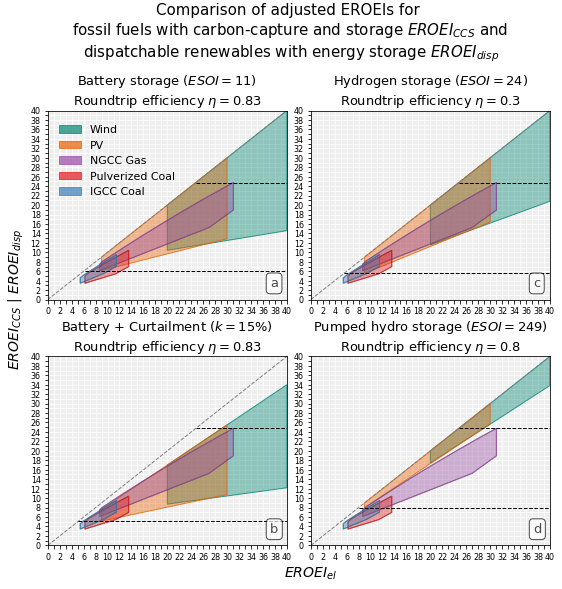

In [257]:
#Plots init
fig,axes=plt.subplots(2,2,figsize=(9,8),subplot_kw=dict(facecolor='#EEEEEE',axisbelow=True))
for axi in axes:
    for ax in axi:
        ax.grid(color='white', linestyle='solid')                       
plt.subplots_adjust(wspace=0.1)
plt.subplots_adjust(hspace=0.3)

legendalpha=0.7

#RE part
for i in range(len(eroei_disp_n))[::-1]:
    print 'calculating '+eroei_ren_names[i]+' convex hull...'
    for j in range(len(eroei_disp_n[i])):
        points=[]
        for eroi in range(len(eroei_disp_n[i][j])):
            x0=eroei_el_ren[i][eroi]
            y0min=min(eroei_disp_n[i][j][eroi].flatten())
            y0max=max(eroei_disp_n[i][j][eroi].flatten())
            points.append([x0,y0min])
            points.append([x0,y0max])

        colr=cbrew(4-i)
        ax=axes[j/2][j%2]
        poly = plt.Polygon(convexhull(points), edgecolor="none",facecolor=colr,alpha=0.4)
        poly2 = plt.Polygon(convexhull(points), edgecolor=colr,alpha=0.8,fill=False,lw=1)
        legendpoly = plt.Polygon([[0,0],[0,-1],[-1,-1]], edgecolor=colr,facecolor=colr,alpha=legendalpha,lw=1,label=eroei_ren_names[i])
        ax.add_patch(poly)
        ax.add_patch(poly2)
        ax.add_patch(legendpoly)
        if (i==0):
            if (j!=2):
                ax.set_title(ESOI_tech[j]+u' ($ESOI='+str(ESOI[j])+\
                     '$)\nRoundtrip efficiency $\eta='+str(eta[j])+'$',fontsize=13)
            else:
                ax.set_title(ESOI_tech[j]+u' ($k='+str(int(c[j]*100))+\
                     '$%)\nRoundtrip efficiency $\eta='+str(eta[j])+'$',fontsize=13)
            ax.text(0.93, 0.12, string.ascii_lowercase[(j%2)*2+j/2],
                    horizontalalignment='left',
                    verticalalignment='top',
                    transform=ax.transAxes,size=13,alpha=0.7,
                    bbox=dict(boxstyle="round", fc="w", alpha=0.7))
            ax.plot([0,100],[0,100],c='grey',lw=1,ls='--')
            ax.plot([re_bottom[j],100],[re_bottom[j],re_bottom[j]],c='k',lw=1,ls='--')
            ax.plot([fs_top,100],[fs_top,fs_top],c='k',lw=1,ls='--')

#Fossil part
for i in range(len(names)):
    points=[]
    print 'calculating '+names[i].replace('\n',' ')+' convex hull...'
    for eroi in range(len(eroei_el_ns[i])):
        for j in range(len(CF)):
        #for j in range(1,2):
            x0=eroei_el_cf_N[i][eroi][0][j]
            y0min=min(eroei_ccs_min_N[i][eroi][0][j])
            y0max=max(eroei_ccs_max_N[i][eroi][0][j])
            points.append([x0,y0min])
            points.append([x0,y0max])
                              
    for axi in axes:
        for ax in axi:
            colr=cbrew(i)
            poly = plt.Polygon(convexhull(points), edgecolor="k",facecolor=colr,alpha=0.4)
            poly2 = plt.Polygon(convexhull(points), edgecolor=colr,alpha=0.8,fill=False,lw=1)
            legendpoly = plt.Polygon([[0,0],[0,-1],[-1,-1]], edgecolor=colr,facecolor=colr,alpha=legendalpha,lw=1,label=names[i].replace('\n',' '))
            ax.add_patch(poly)
            ax.add_patch(poly2)
            ax.add_patch(legendpoly)

#Format labels
axes[0][0].set_ylabel('$EROEI_{CCS}$ | $EROEI_{disp}$',fontsize=14,y=0)
axes[1][1].set_xlabel('$EROEI_{el}$',fontsize=14,x=0)        
maxlabel=max(np.array(eroei_el_ren).flatten())
labelrange=[i if i%2==0 else '' for i in range(int(maxlabel)+1) ]
for axi in axes:
    for ax in axi:
        ax.set_xlim(0,maxlabel)
        ax.set_ylim(0,maxlabel)
        ax.set_xticks(range(int(maxlabel)+1))
        ax.set_yticks(range(int(maxlabel)+1))
        ax.set_yticks(range(int(maxlabel)+1))
        ax.set_xticklabels(labelrange,fontsize=8)   
        ax.set_yticklabels(labelrange,fontsize=8) 

#axes[0][1].legend(loc=(1.04,0.58),fontsize=11)       
axes[0][0].legend(loc=(0.03,0.52),framealpha=0,fontsize=11)       
        
plt.suptitle('Comparison of adjusted EROEIs for \nfossil fuels with carbon-capture and storage $EROEI_{CCS}$ and \ndispatchable renewables with energy storage $EROEI_{disp}$',y=1.06,fontsize=15)
plt.savefig('plot/fig4_annotated.png',dpi=150,bbox_inches = 'tight', pad_inches = 0.1)
plt.show()

Shaded area plots

In [258]:
def alpharater(g,n,t):
    if g<t*n:
        return (g+1)*1.0/(t*n)
    elif g+1>(1-t)*n:
        return ((n-g))*1.0/(t*n)
    else:
        return 1

calculating Wind segment-wise convex hull...
calculating PV segment-wise convex hull...
calculating NGCC Gas segment-wise convex hull...
calculating Pulverized Coal segment-wise convex hull...
calculating IGCC Coal segment-wise convex hull...


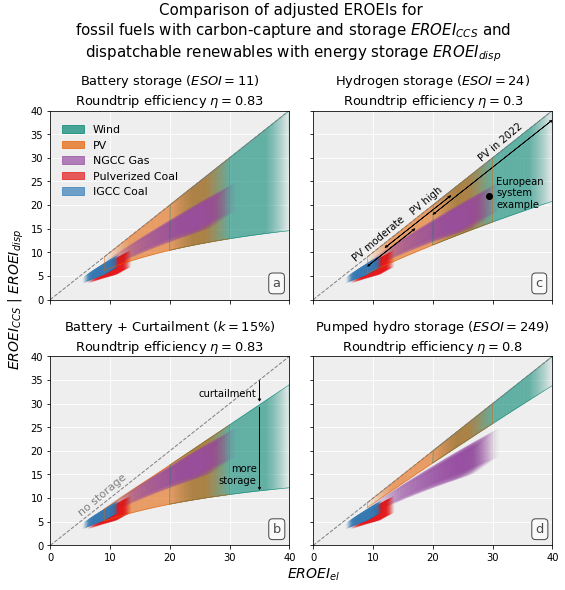

In [281]:
#Plots init
fig,axes=plt.subplots(2,2,figsize=(9,8),subplot_kw=dict(facecolor='#EEEEEE',axisbelow=True))
for axi in axes:
    for ax in axi:
        ax.grid(color='white', linestyle='solid')                       
plt.subplots_adjust(wspace=0.1)
plt.subplots_adjust(hspace=0.3)
legendalpha=0.7

#RE part
for i in range(len(eroei_disp_n))[::-1]:
    print 'calculating '+eroei_ren_names[i]+' segment-wise convex hull...'
    for j in range(len(eroei_disp_n[i])):
        points=[]
        for eroi in range(len(eroei_disp_n[i][j])):
            x0=eroei_el_ren[i][eroi]
            y0min=min(eroei_disp_n[i][j][eroi].flatten())
            y0max=max(eroei_disp_n[i][j][eroi].flatten())
            points.append([x0,y0min])
            points.append([x0,y0max])

        colr=cbrew(4-i)
        ax=axes[j/2][j%2]
        nfaces=200
        tfaces=0.2
        basealpha=0.3
        for g,p in enumerate(np.split(np.array(points),nfaces)):
            psegment=convexhull(p)
            poly = plt.Polygon(psegment, edgecolor=colr,
                               alpha=basealpha*alpharater(g,nfaces,tfaces),fill=False,lw=0.95)
            ax.add_patch(poly)
            ax.plot(psegment.T[0][:2],psegment.T[1][:2],c=colr,alpha=0.9,lw=0.5)
            ax.plot(psegment.T[0][2:],psegment.T[1][2:],c=colr,alpha=0.9,lw=0.5)
            if g==0:
                ax.plot(psegment.T[0][0::2],psegment.T[1][0::2],c=colr,alpha=0.9,lw=0.5)
            if g==len(np.split(np.array(points),nfaces))-1:
                ax.plot(psegment.T[0][1::2],psegment.T[1][1::2],c=colr,alpha=0.9,lw=0.5)
        legendpoly = plt.Polygon([[0,0],[0,-1],[-1,-1]], edgecolor=colr,facecolor=colr,alpha=legendalpha,lw=1,label=eroei_ren_names[i])
        ax.add_patch(legendpoly)
        if (i==0):
            if (j!=2):
                ax.set_title(ESOI_tech[j]+u' ($ESOI='+str(ESOI[j])+\
                     '$)\nRoundtrip efficiency $\eta='+str(eta[j])+'$',fontsize=13)
            else:
                ax.set_title(ESOI_tech[j]+u' ($k='+str(int(c[j]*100))+\
                     '$%)\nRoundtrip efficiency $\eta='+str(eta[j])+'$',fontsize=13)
            ax.text(0.93, 0.12, string.ascii_lowercase[(j%2)*2+j/2],
                    horizontalalignment='left',
                    verticalalignment='top',
                    transform=ax.transAxes,size=13,alpha=0.7,
                    bbox=dict(boxstyle="round", fc="w", alpha=0.7))
            ax.plot([0,100],[0,100],c='grey',lw=1,ls='--')
            if (j==2): 
                ax.text(0.22, 0.27, 'no storage',
                        horizontalalignment='center',
                        verticalalignment='center',
                        transform=ax.transAxes,size=11,rotation=40, color='grey')
                ax.arrow(35, 35, 0, -4, head_width=0.5, head_length=0.5, fc='k', ec='k',ls='-',lw=0.5)
                ax.arrow(35, 29.3, 0, -17, head_width=0.5, head_length=0.5, fc='k', ec='k',ls='-',lw=0.5)
                ax.text(34.5, 32, 'curtailment',
                        horizontalalignment='right',
                        verticalalignment='center', rotation=0, color='k')
                ax.text(34.5, 15, 'more\nstorage',
                        horizontalalignment='right',
                        verticalalignment='center', rotation=0, color='k')
            if (j==1):
                arrowoffset=[2,1,2]
                arrowtext=['PV moderate       ','   PV high','PV in 2022']
                for a in range(len(eroei_el_pv)):
                    x1,y1=eroei_el_pv[a][0], eroei_el_pv[a][0]-arrowoffset[a]
                    w1,h1=eroei_el_pv[a][1]-eroei_el_pv[a][0],eroei_el_pv[a][1]-eroei_el_pv[a][0]
                    ax.arrow(x1,y1,w1,h1,length_includes_head=True,
                             head_width=0.5, head_length=0.5, fc='k', ec='k',ls='-',lw=0.5)
                    ax.arrow(x1+w1,y1+h1,-w1,-h1,length_includes_head=True,
                             head_width=0.5, head_length=0.5, fc='k', ec='k',ls='-',lw=0.5)
                    ax.text(x1+w1/1.5-arrowoffset[a], y1+h1/1.5+2, arrowtext[a],
                        horizontalalignment='center',
                        verticalalignment='center', rotation=40, color='k')
                
                x2=eroei_el_eu[0][0]*eroei_el_eu[1][0]+eroei_el_eu[0][1]*eroei_el_eu[1][1]
                y2=eroei_el_eu[2]
                ax.scatter([x2],[y2],color='k',zorder=100)
                ax.text(x2*1.04, y2*1.03, 'European\nsystem\nexample',
                        horizontalalignment='left',
                        verticalalignment='center', rotation=0, color='k')

#Fossil part
for i in range(len(names)):
    points=[]
    print 'calculating '+names[i].replace('\n',' ')+' segment-wise convex hull...'
    for eroi in range(len(eroei_el_ns[i])):
        for j in range(len(CF)):
        #for j in range(1,2):
            x0=eroei_el_cf_N[i][eroi][0][j]
            y0min=min(eroei_ccs_min_N[i][eroi][0][j])
            y0max=max(eroei_ccs_max_N[i][eroi][0][j])
            points.append([x0,y0min])
            points.append([x0,y0max])
                              
    for axi in axes:
        for ax in axi:
            colr=cbrew(i)
            nfaces=100
            tfaces=0.24
            basealpha=0.15
            for g,p in enumerate(np.split(np.array(points),nfaces)):
                psegment=convexhull(p)
                poly = plt.Polygon(convexhull(p), edgecolor=colr, facecolor=colr,
                                   alpha=basealpha*alpharater(g,nfaces,tfaces),lw=1)
                ax.add_patch(poly)
                #ax.plot(psegment.T[0][:2],psegment.T[1][:2],c=colr,alpha=0.9,lw=0.5)
                #ax.plot(psegment.T[0][2:],psegment.T[1][2:],c=colr,alpha=0.9,lw=0.5)
                #if g==0:
                #    ax.plot(psegment.T[0][0::2],psegment.T[1][0::2],c=colr,alpha=0.9,lw=0.5)
                #if g==len(np.split(np.array(points),nfaces))-1:
                #    ax.plot(psegment.T[0][1::2],psegment.T[1][1::2],c=colr,alpha=0.9,lw=0.5)
            legendpoly = plt.Polygon([[0,0],[0,-1],[-1,-1]], edgecolor=colr,facecolor=colr,alpha=legendalpha,lw=1,label=names[i].replace('\n',' '))
            ax.add_patch(legendpoly)

#Format labels
for axi in axes:
    for ax in axi:
        ax.set_xlim(0,max(np.array(eroei_el_ren).flatten()))
        ax.set_ylim(0,max(np.array(eroei_el_ren).flatten()))
axes[0][0].set_ylabel('$EROEI_{CCS}$ | $EROEI_{disp}$',fontsize=14,y=0)
axes[1][1].set_xlabel('$EROEI_{el}$',fontsize=14,x=0)        
axes[0][1].set_yticklabels('')   
axes[1][1].set_yticklabels('')   
axes[0][0].set_xticklabels('')   
axes[0][1].set_xticklabels('')  
#axes[0][1].legend(loc=(1.04,0.58),fontsize=11)       
axes[0][0].legend(loc=(0.03,0.52),framealpha=0,fontsize=11)       
        
plt.suptitle('Comparison of adjusted EROEIs for \nfossil fuels with carbon-capture and storage $EROEI_{CCS}$ and \ndispatchable renewables with energy storage $EROEI_{disp}$',y=1.06,fontsize=15)
plt.savefig('plot/fig4.png',dpi=150,bbox_inches = 'tight', pad_inches = 0.1)
plt.show()

Close Excel workbook.

In [282]:
wb.close()

### Auxiliary plots

In [196]:
df=pd.read_excel('cfdata.xlsx')

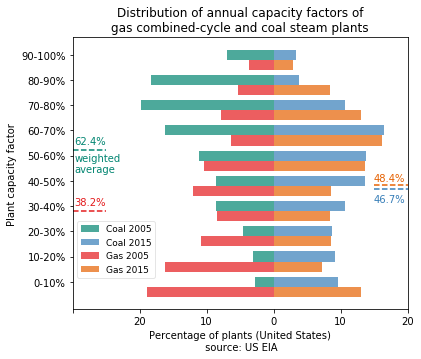

In [197]:
fig,ax=plt.subplots(1,1,figsize=(6,5))
ax.barh(df.index,-df['PC 2005']/sum(df['PC 2005'])*100,0.4,color=cbrew(3),label='Coal 2005',alpha=legendalpha)
ax.barh(df.index,df['PC 2015']/sum(df['PC 2015'])*100,0.4,color=cbrew(2),label='Coal 2015',alpha=legendalpha)
ax.barh(df.index-0.4,-df['NG 2005']/sum(df['NG 2005'])*100,0.4,color=cbrew(1),label='Gas 2005',alpha=legendalpha)
ax.barh(df.index-0.4,df['NG 2015']/sum(df['NG 2015'])*100,0.4,color=cbrew(4),label='Gas 2015',alpha=legendalpha)
z=np.average(df.index+0.5,weights=df['NG 2005'])-1
ax.plot([-30,-25],[z,z],ls='--',color=cbrew(1))
ax.text(-29.7,z+0.2,str(np.round((z+1)*10,1))+ '%',color=cbrew(1))
z=np.average(df.index+0.5,weights=df['NG 2015'])-1
ax.plot([15,20],[z,z],ls='--',color=cbrew(4))
ax.text(15,z+0.15,str(np.round((z+1)*10,1))+ '%',color=cbrew(4))
z=np.average(df.index+0.5,weights=df['PC 2005'])-1
ax.plot([-30,-25],[z,z],ls='--',color=cbrew(3))
ax.text(-29.7,z+0.2,str(np.round((z+1)*10,1))+ '%',color=cbrew(3))
ax.text(-29.7,z-0.9,'weighted\naverage',color=cbrew(3))
z=np.average(df.index+0.5,weights=df['PC 2015'])-1
#z=np.average(df.index+0.5)-1
ax.plot([15,20],[z,z],ls='--',color=cbrew(2))
ax.text(15,z-0.5,str(np.round((z+1)*10,1))+ '%',color=cbrew(2))

fig.canvas.draw()
labels = ['']+[item.get_text().replace(u'\u2212','') for item in ax.get_xticklabels()[2:-1]]+['']
ax.set_xticklabels(labels)
ax.set_yticks(df.index)
ax.set_xlim([-30,20])
ax.set_yticklabels(df['CF'][::-1])
ax.legend(bbox_to_anchor=(0.26, 0.22),framealpha=0.5,fontsize=9)
ax.set_ylabel('Plant capacity factor')
ax.set_xlabel('Percentage of plants (United States)\n source: US EIA')
ax.set_title('Distribution of annual capacity factors of\ngas combined-cycle and coal steam plants')
plt.savefig('plot/figS2.png',dpi=150,bbox_inches = 'tight', pad_inches = 0.1)
plt.show()

In [198]:
import seaborn as sns  

In [199]:
dg=[]
fuel_label={'NG':' ','PC':'  '} #just needed for pretty labels
for label in [u'NG 2005', u'NG 2015', u'PC 2015', u'PC 2005']:
    h1=df[[label]]
    for i in h1.index:
        for j in range(int(abs(h1.loc[i][label]))):
            dg.append({'Fuel':fuel_label[label[:2]],'Year':int(label[-4:]),'Capacity factor':(0.5+i)*10})

In [200]:
dh=pd.DataFrame(dg)
dh.head()

,Capacity factor,Fuel,Year
0,5.0,,2005
1,5.0,,2005
2,5.0,,2005
3,5.0,,2005
4,5.0,,2005


C:\Users\csala\AppData\Local\Continuum\anaconda2\envs\python2\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


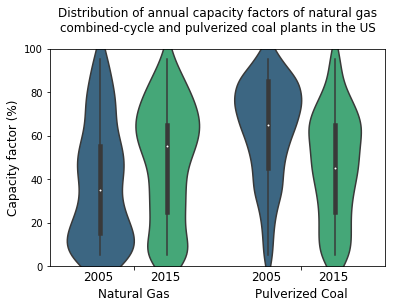

In [201]:
sns.violinplot(data=dh,x='Fuel',hue='Year',y='Capacity factor',palette="viridis")
plt.title('Distribution of annual capacity factors of natural gas\ncombined-cycle and pulverized coal plants in the US',y=1.05)
plt.xlabel('')
plt.ylabel('Capacity factor (%)',fontsize=12)
plt.legend().set_visible(False)
ax=plt.gca()
ax.text(0.1, -0.02, 2005,
                horizontalalignment='left',
                verticalalignment='top',
                transform=ax.transAxes,size=12)
ax.text(0.3, -0.02, 2015,
                horizontalalignment='left',
                verticalalignment='top',
                transform=ax.transAxes,size=12)
ax.text(0.6, -0.02, 2005,
                horizontalalignment='left',
                verticalalignment='top',
                transform=ax.transAxes,size=12)
ax.text(0.8, -0.02, 2015,
                horizontalalignment='left',
                verticalalignment='top',
                transform=ax.transAxes,size=12)
ax.text(0.75, -0.1, 'Pulverized Coal',
                horizontalalignment='center',
                verticalalignment='top',
                transform=ax.transAxes,size=12)
ax.text(0.25, -0.1, 'Natural Gas',
                horizontalalignment='center',
                verticalalignment='top',
                transform=ax.transAxes,size=12)

plt.ylim(0,100)   
plt.savefig('plot/figS2b.png',dpi=150,bbox_inches = 'tight', pad_inches = 0.1)
plt.show()

[Denes Csala](https://csaladen.es) | MIT License | 2018